This BRATS Location Regression Model is based on Gabriel Atkin (2021) Age Prediction From Facial Images Model. Available at: https://www.kaggle.com/gcdatkin/age-prediction-from-images-cnn-regression [Last Accessed 30 July 2021]

Save BRATS Images

In [ ]:
# upload dataset here (deprecated for full dataset- using google drive mounting method)
# from google.colab import files
# datasetfile = files.upload()

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#converts image to 225x225
def makeSquare(image):
  return cv2.resize(image, dsize=(225, 225), interpolation=cv2.INTER_CUBIC)

In [ ]:
# import nibabel and os module for image formatting and file management
import cv2
import nibabel as nib
import os

from scipy import ndimage

# lists to store slices
imgList = []
#labelList = [*range(0, 9)]

# place slices into lists
def store_img(file):
  bratsImg = nib.load(file)
  bratsImgData = bratsImg.get_fdata()

  i = 100
  while i < 105:
    # rotate images to 0 degrees + store in list
    rotatedImg = ndimage.rotate(bratsImgData[:,:,i], 90, mode = 'mirror')
    rotatedImg = makeSquare(rotatedImg)
    imgList.append(rotatedImg.copy())   

    i += 1

count = 0
# extract flair files from BRATS HGG + LGG data folders
dirLGG = '/content/drive/MyDrive/URVOS/Brats_2018_data.zip (Unzipped Files)/Brats_2018 data/LGG/'
for folder in os.listdir(dirLGG):
  for file in os.listdir(dirLGG + folder + '/'):
    if count < 30:
      if file.endswith("flair.nii.gz"):
        store_img(dirLGG + folder + '/' + file)
dirHGG = '/content/drive/MyDrive/URVOS/Brats_2018_data.zip (Unzipped Files)/Brats_2018 data/HGG/'
for folder in os.listdir(dirHGG):
  for file in os.listdir(dirHGG + folder + '/'):
  #if count < 30:
    if file.endswith("flair.nii.gz"):
      store_img(dirHGG + folder + '/' + file)
      #count +=1

(9, 75, 75)


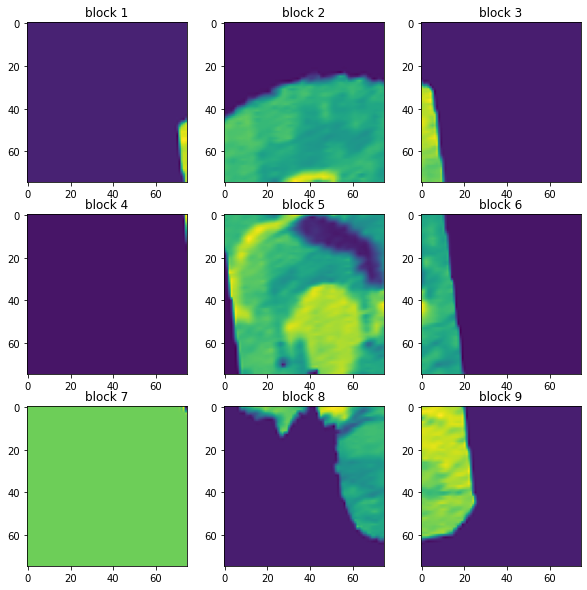

In [ ]:
import numpy as np

def blockify(image):
  #reshape into 4 parts
  square_blocks = image.reshape(3, 75, 3, 75,).swapaxes(2, 1)
  square_blocks = square_blocks.reshape(-1, 75, 75)
  return square_blocks

brain1 = blockify(imgList[4])
print(np.shape(brain1))

from matplotlib import pyplot as plt
for i, block in enumerate(brain1):
    plt.figure(10+i//9, figsize = (10, 10))
    plt.subplot(3, 3, i%9+1)
    plt.imshow(block)
    plt.title(f'block {i+1}')

In [ ]:
# #testing seperating blocks
# list0 = []
# list1 = []
# list2 = []
# list3 = []
# list4 = []
# list5 = []
# list6 = []
# list7 = []
# list8 = []

# #add block to its array
# for i, block in enumerate(brain1):
#   exec("list"+str(i)+".append(block)")

# print(len(list0))
# #show contents of list0
# plt.figure()
# plt.imshow(list0[0])
# #show contents of list1
# plt.figure()
# plt.imshow(list1[0])

In [ ]:
# create directories for each label
mainDir = '/content/gdrive/bratsContextRegression/'

for i in range(1,10):
  if not os.path.exists(mainDir + str(i) + '/'):
      os.makedirs(mainDir + str(i) + '/')

In [ ]:
# add list images to corresponding directories
myPath = os.path.abspath(mainDir)

j = 1
ind = 0
while ind < len(imgList):
  blocks = blockify(imgList[ind])
  for i, block in enumerate(blocks):
    plt.imsave(myPath + '/' + str(i+1) + '/' + str(j) + '.jpg', block)
    j += 1
  ind += 1

Create File Dataframe

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
image_dir = Path('/content/gdrive/bratsContextRegression')

# retrieve image directories and location labels
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
locations = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Location').astype(np.int)

images = pd.concat([filepaths, locations], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

images

,Filepath,Location
0,/content/gdrive/bratsContextRegression/3/39.jpg,3
1,/content/gdrive/bratsContextRegression/3/6168.jpg,3
2,/content/gdrive/bratsContextRegression/6/10752...,6
3,/content/gdrive/bratsContextRegression/6/492.jpg,6
4,/content/gdrive/bratsContextRegression/6/11058...,6
...,...,...
12820,/content/gdrive/bratsContextRegression/4/11191...,4
12821,/content/gdrive/bratsContextRegression/6/6252.jpg,6
12822,/content/gdrive/bratsContextRegression/1/11665...,1
12823,/content/gdrive/bratsContextRegression/8/9836.jpg,8


In [ ]:
image_df = images

# assign 70% of images to train set
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

Load Images


In [ ]:
import tensorflow as tf

In [ ]:
# specify transformations
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # test set at 20%
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Location',
    target_size=(75,75),
    class_mode='raw',
    batch_size=25,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Location',
    target_size=(75,75),
    class_mode='raw',
    batch_size=25,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Location',
    target_size=(75,75),
    class_mode='raw',
    batch_size=25,
    shuffle=False
)

Found 7182 validated image filenames.
Found 1795 validated image filenames.
Found 3848 validated image filenames.


Training

In [ ]:
inputs = tf.keras.Input(shape=(75,75, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                   monitor='val_loss',
                   patience=5,
                   restore_best_weights=True
                   )
               ]
)

Epoch 1/100
288/288 [==============================] - 35s 19ms/step - loss: 2.4699 - val_loss: 1.6828
Epoch 2/100
288/288 [==============================] - 5s 18ms/step - loss: 0.7619 - val_loss: 0.6829
Epoch 3/100
288/288 [==============================] - 5s 19ms/step - loss: 0.4404 - val_loss: 0.5435
Epoch 4/100
288/288 [==============================] - 5s 18ms/step - loss: 0.4029 - val_loss: 0.3396
Epoch 5/100
288/288 [==============================] - 5s 18ms/step - loss: 0.3461 - val_loss: 0.4798
Epoch 6/100
288/288 [==============================] - 5s 18ms/step - loss: 0.3174 - val_loss: 0.3435
Epoch 7/100
288/288 [==============================] - 5s 18ms/step - loss: 0.2996 - val_loss: 0.2905
Epoch 8/100
288/288 [==============================] - 5s 18ms/step - loss: 0.2452 - val_loss: 0.2612
Epoch 9/100
288/288 [==============================] - 5s 18ms/step - loss: 0.2556 - val_loss: 0.2224
Epoch 10/100
288/288 [==============================] - 5s 18ms/step - loss: 0.20

Results

In [ ]:
from sklearn.metrics import r2_score

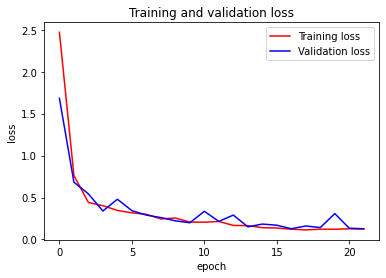

<Figure size 432x288 with 0 Axes>

Test RMSE: 0.34929
Test R^2 Score: 98.17407%


In [ ]:
# plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc=0)
plt.figure()

plt.show()

predicted_locations = np.squeeze(model.predict(test_images))
true_locations = test_images.labels

# root mean square error - average distance between the predicted values from the model and the actual values in the dataset
rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("Test RMSE: {:.5f}".format(rmse))

# r2 score - to what extent the variance of one variable explains the variance of the second variable
r2 = r2_score(true_locations, predicted_locations)
print("Test R^2 Score: {:.5f}%".format(r2*100))

In [ ]:
# #test out-of-sample images by SEPERATE UPLOAD
# from google.colab import files
# from keras.preprocessing import image

# uploaded = files.upload()

# for fn in uploaded.keys():
#   path = fn
#   img = image.load_img(path, target_size = (75,75))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis = 0)

#   images = np.vstack([x])
#   location = model.predict(images, batch_size=1)
#   print("\nLocation: " + str(round(location[0][0])))

In [ ]:
#get test images and files from dataframe
imagesList = test_df['Filepath'].to_list()
actualLocation = test_df['Location'].to_list()
print(actualLocation)

[4, 1, 5, 2, 9, 7, 4, 2, 2, 3, 6, 2, 1, 5, 3, 1, 3, 8, 3, 5, 5, 9, 1, 1, 1, 6, 9, 5, 6, 5, 7, 2, 5, 5, 9, 4, 8, 6, 9, 4, 4, 9, 6, 8, 1, 6, 5, 2, 5, 8, 2, 8, 3, 1, 7, 8, 7, 1, 6, 6, 9, 9, 1, 4, 4, 5, 3, 9, 8, 5, 2, 8, 3, 9, 2, 2, 9, 5, 5, 6, 6, 9, 6, 4, 1, 9, 6, 1, 7, 1, 7, 7, 6, 7, 1, 5, 8, 7, 5, 9, 5, 3, 6, 9, 9, 1, 8, 2, 5, 6, 2, 1, 4, 5, 8, 2, 9, 8, 9, 9, 3, 3, 6, 7, 9, 4, 3, 4, 2, 6, 4, 9, 3, 6, 1, 1, 4, 5, 9, 1, 9, 3, 5, 6, 9, 1, 7, 7, 8, 3, 2, 4, 9, 5, 4, 7, 5, 3, 7, 3, 3, 1, 3, 9, 4, 8, 4, 5, 5, 2, 8, 5, 4, 4, 7, 6, 5, 7, 4, 1, 2, 3, 7, 5, 9, 4, 3, 2, 9, 2, 9, 8, 2, 7, 8, 2, 2, 6, 3, 2, 8, 1, 7, 4, 5, 7, 8, 2, 4, 6, 5, 8, 2, 9, 2, 9, 1, 3, 5, 4, 1, 1, 5, 6, 2, 3, 9, 1, 6, 2, 6, 4, 9, 6, 9, 4, 9, 8, 3, 6, 2, 9, 6, 7, 7, 6, 6, 3, 1, 6, 7, 7, 7, 8, 5, 6, 4, 1, 3, 1, 8, 8, 8, 4, 4, 5, 4, 3, 7, 4, 2, 2, 3, 4, 3, 4, 7, 8, 9, 6, 2, 6, 3, 7, 9, 3, 2, 8, 9, 8, 6, 7, 1, 7, 7, 5, 5, 1, 1, 6, 4, 4, 6, 6, 8, 5, 3, 4, 8, 3, 1, 5, 2, 5, 4, 3, 6, 6, 1, 7, 9, 5, 7, 9, 5, 5, 7, 1, 9, 6, 4, 4, 7, 

In [ ]:
#test images from test dataframe
import numpy as np
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


#Testing Out of Sample directory Images

predLocation = [] #holds values of predictions


def predictArray(pathList):
  for img in pathList:
      img = image.load_img(img, target_size=(75,75))
      img = image.img_to_array(img)
      img = np.expand_dims(img, axis=0)


      location = model.predict(img, batch_size=1)
      location = np.rint(location)
      location = int(location[0][0])
      predLocation.append(location)#adds to prediction array

predictArray(imagesList)


In [ ]:
print(predLocation)

[4, 1, 5, 2, 9, 7, 4, 2, 2, 3, 6, 2, 1, 5, 3, 1, 3, 8, 3, 5, 5, 9, 1, 1, 1, 6, 9, 5, 6, 5, 7, 2, 5, 5, 9, 4, 8, 6, 9, 4, 4, 9, 6, 8, 1, 6, 5, 2, 5, 8, 2, 8, 3, 1, 7, 8, 7, 1, 6, 6, 9, 9, 1, 4, 4, 5, 3, 9, 8, 5, 2, 8, 3, 9, 2, 2, 9, 5, 5, 6, 6, 9, 6, 4, 1, 9, 6, 1, 7, 1, 7, 6, 6, 7, 1, 5, 8, 7, 5, 9, 5, 3, 6, 9, 9, 1, 8, 2, 6, 6, 2, 1, 4, 5, 8, 2, 9, 8, 9, 9, 3, 3, 6, 6, 9, 4, 3, 4, 2, 6, 4, 9, 3, 6, 1, 1, 4, 5, 9, 1, 9, 3, 5, 6, 9, 1, 7, 6, 8, 3, 2, 4, 9, 5, 4, 7, 6, 3, 7, 3, 3, 1, 3, 9, 4, 8, 4, 5, 5, 2, 8, 5, 4, 4, 7, 6, 5, 7, 4, 1, 2, 3, 7, 5, 9, 4, 3, 2, 9, 2, 9, 8, 2, 7, 8, 2, 2, 7, 3, 2, 8, 1, 7, 4, 5, 6, 8, 2, 4, 6, 5, 8, 2, 9, 2, 9, 1, 3, 5, 4, 1, 1, 5, 6, 2, 3, 8, 1, 6, 2, 6, 4, 9, 6, 9, 4, 9, 8, 3, 6, 2, 9, 6, 7, 7, 6, 6, 3, 2, 6, 3, 6, 7, 8, 5, 6, 4, 1, 3, 1, 8, 8, 8, 4, 4, 5, 4, 3, 6, 4, 2, 2, 3, 4, 3, 4, 7, 8, 9, 6, 2, 6, 3, 7, 9, 3, 2, 8, 9, 8, 6, 6, 1, 7, 7, 5, 5, 1, 1, 6, 4, 4, 6, 6, 8, 5, 3, 4, 8, 3, 2, 5, 2, 5, 4, 3, 6, 6, 1, 7, 9, 5, 7, 9, 5, 5, 7, 1, 9, 6, 4, 4, 7, 

[[430  11   1   0   0   0   0   0   0]
 [  0 409   2   0   0   0   0   0   0]
 [  0   3 401   3   1   1   4   0   0]
 [  0   0   6 377  28   0   4   0   0]
 [  0   0   2   5 427  18   2   0   0]
 [  0   0   0   0   0 432   6   0   0]
 [  0   1   3   3   2  49 369   1   0]
 [  0   0   0   0   3   1  15 384   1]
 [  0   0   0   0   0   0   3  23 417]]


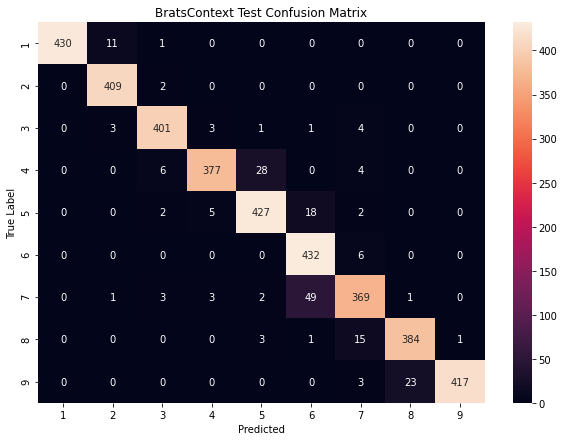

In [ ]:
#Confusion Matrix

labels = [1,2,3,4,5,6,7,8,9]
the_matrix = confusion_matrix(actualLocation, predLocation, labels=labels)
print(the_matrix)

df_cfm = pd.DataFrame(the_matrix, index = labels, columns = labels)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True, fmt='g')
cfm_plot.set_title('BratsContext Test Confusion Matrix')
cfm_plot.set_xlabel('Predicted')
cfm_plot.set_ylabel('True Label')
cfm_plot.figure.savefig("cfm.png")